In [61]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

# === 1. Загрузка данных ===

# Загрузка train.csv
cwd = os.getcwd()
file_path = os.path.join(cwd, r'hw_6_data\train.csv')  # Замените на путь к вашему CSV файлу
df = pd.read_csv(file_path, parse_dates=["date"])

# === 2. Проверка и обработка пропусков ===
print(df.isnull().sum())  # Проверка

# Заполним NaN в числовых колонках медианой (если вдруг есть)
for col in df.select_dtypes(include=["float64", "int64"]):
    df[col] = df[col].fillna(df[col].median())

# В категориальных признаках заполним None модой
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    if df[col].isnull().sum() > 0:
        mode = df[col].mode()[0]
        df[col].fillna(mode, inplace=True)

# === 3. Извлечение признаков из даты ===
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

# Синусоидальные признаки (для цикличности)
df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

# === 4. Сортировка и генерация лагов ===
df = df.sort_values(by=["store", "item", "date"])

# Лаги
for lag in [1, 7, 14]:
    df[f"lag_{lag}"] = df.groupby(["store", "item"])["sales"].shift(lag)

# Скользящие средние
for window in [7, 14]:
    df[f"rolling_mean_{window}"] = (
        df.groupby(["store", "item"])["sales"]
        .shift(1)
        .rolling(window=window)
        .mean()
    )

# === 5. Обработка NaN, возникших из-за лагов и rolling ===
lag_cols = [col for col in df.columns if "lag_" in col or "rolling_mean" in col]
for col in lag_cols:
    df[col] = df[col].fillna(0)  # можно заменить на медиану: df[col].fillna(df[col].median())

# === 6. Кодирование категориальных признаков ===
le_store = LabelEncoder()
le_item = LabelEncoder()
df["store"] = le_store.fit_transform(df["store"])
df["item"] = le_item.fit_transform(df["item"])

# === 7. Копия для обучения (без поля даты) ===
df_model = df.copy()
df_model.drop(columns=["date"], inplace=True)

# === 8. Финальный вид ===
print("Готово! Размер итогового датафрейма для обучения:", df_model.shape)
display(df_model.head())


date     0
store    0
item     0
sales    0
dtype: int64
Готово! Размер итогового датафрейма для обучения: (913000, 15)


,store,item,sales,year,month,day,dayofweek,is_weekend,dayofweek_sin,dayofweek_cos,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14
0,0,0,13,2013,1,1,1,0,0.78183,0.62349,0.00000,0.00000,0.00000,0.00000,0.00000
1,0,0,11,2013,1,2,2,0,0.97493,-0.22252,13.00000,0.00000,0.00000,0.00000,0.00000
2,0,0,14,2013,1,3,3,0,0.43388,-0.90097,11.00000,0.00000,0.00000,0.00000,0.00000
3,0,0,13,2013,1,4,4,0,-0.43388,-0.90097,14.00000,0.00000,0.00000,0.00000,0.00000
4,0,0,10,2013,1,5,5,1,-0.97493,-0.22252,13.00000,0.00000,0.00000,0.00000,0.00000


In [62]:
import optuna
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# === Данные ===
X = df_model.drop(columns=["sales"])
y = df_model["sales"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [63]:
# 1. RandomForestRegressor

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

MAX_EVALS = 1  # можно увеличить после тестов

# Пространство поиска гиперпараметров
space_rf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']),
}

# Целевая функция для минимизации
def objective_rf(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': params['max_features'],
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return {'loss': rmse, 'status': STATUS_OK}

In [64]:
# 2. Gradient Boosting (HistGradientBoostingRegressor)

from sklearn.ensemble import HistGradientBoostingRegressor

def objective_hgb(params):
    model = HistGradientBoostingRegressor(
        max_iter=int(params['max_iter']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        l2_regularization=params['l2_regularization'],
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    loss = mean_squared_error(y_valid, preds)
    return loss

space_hgb = {
    'max_iter': hp.quniform('max_iter', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'l2_regularization': hp.loguniform('l2_regularization', np.log(1e-4), np.log(1.0)),
}


In [65]:
# 3. XGBoost

import xgboost as xgb

def objective_xgb(params):
    model = xgb.XGBRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    loss = mean_squared_error(y_valid, preds)
    return loss

space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}


In [66]:
# 4. LightGBM

import lightgbm as lgb

def objective_lgb(params):
    model = lgb.LGBMRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        num_leaves=int(params['num_leaves']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    loss = mean_squared_error(y_valid, preds)
    return loss

space_lgb = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 10),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}


In [67]:
# 5. CatBoost

from catboost import CatBoostRegressor

def objective_cat(params):
    model = CatBoostRegressor(
        iterations=int(params['iterations']),
        depth=int(params['depth']),
        learning_rate=params['learning_rate'],
        l2_leaf_reg=params['l2_leaf_reg'],
        verbose=0,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    loss = mean_squared_error(y_valid, preds)
    return loss

space_cat = {
    'iterations': hp.quniform('iterations', 50, 200, 10),
    'depth': hp.quniform('depth', 4, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1.0), np.log(10.0)),
}


In [68]:
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error
import numpy as np

MAX_EVALS = 1  # можно увеличить после тестов

# 1. Random Forest (уже был, повторим для шаблона)
trials_rf = Trials()
best_rf = fmin(fn=objective_rf,
               space=space_rf,
               algo=tpe.suggest,
               max_evals=MAX_EVALS,
               trials=trials_rf)

print("Best RF params:", best_rf)

# 2. HistGradientBoosting
trials_hgb = Trials()
best_hgb = fmin(fn=objective_hgb,
                space=space_hgb,
                algo=tpe.suggest,
                max_evals=MAX_EVALS,
                trials=trials_hgb)

print("Best HistGradientBoosting params:", best_hgb)

# 3. XGBoost
trials_xgb = Trials()
best_xgb = fmin(fn=objective_xgb,
                space=space_xgb,
                algo=tpe.suggest,
                max_evals=MAX_EVALS,
                trials=trials_xgb)

print("Best XGBoost params:", best_xgb)

# 4. LightGBM
trials_lgb = Trials()
best_lgb = fmin(fn=objective_lgb,
                space=space_lgb,
                algo=tpe.suggest,
                max_evals=MAX_EVALS,
                trials=trials_lgb)

print("Best LightGBM params:", best_lgb)

# 5. CatBoost
trials_cat = Trials()
best_cat = fmin(fn=objective_cat,
                space=space_cat,
                algo=tpe.suggest,
                max_evals=MAX_EVALS,
                trials=trials_cat)

print("Best CatBoost params:", best_cat)


100%|██████████| 1/1 [00:58<00:00, 58.75s/trial, best loss: 8.069133310359547]
Best RF params: {'max_depth': np.float64(15.0), 'max_features': np.int64(1), 'min_samples_leaf': np.float64(2.0), 'min_samples_split': np.float64(3.0), 'n_estimators': np.float64(160.0)}
100%|██████████| 1/1 [00:05<00:00,  5.34s/trial, best loss: 192.22895110090144]
Best HistGradientBoosting params: {'l2_regularization': np.float64(0.0004541310987879954), 'learning_rate': np.float64(0.013753742226861697), 'max_depth': np.float64(10.0), 'max_iter': np.float64(70.0)}
100%|██████████| 1/1 [00:03<00:00,  3.69s/trial, best loss: 65.76885986328125]
Best XGBoost params: {'colsample_bytree': np.float64(0.7786552398239828), 'learning_rate': np.float64(0.09457265974682048), 'max_depth': np.float64(4.0), 'n_estimators': np.float64(110.0), 'subsample': np.float64(0.6493329290048195)}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035626 seconds.
You can set `force_col_wise=true` 

In [69]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Обучение лучших моделей

# Random Forest
rf = RandomForestRegressor(
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']) if best_rf['max_depth'] is not None else None,
    min_samples_split=int(best_rf['min_samples_split']),
    min_samples_leaf=int(best_rf['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)

# HistGradientBoosting
hgb = HistGradientBoostingRegressor(
    max_iter=int(best_hgb['max_iter']),
    learning_rate=best_hgb['learning_rate'],
    max_depth=int(best_hgb['max_depth']),
    l2_regularization=best_hgb['l2_regularization'],
    early_stopping=True,
    random_state=42
)
hgb.fit(X_train, y_train)
hgb_pred = hgb.predict(X_valid)

# XGBoost
xgb = XGBRegressor(
    n_estimators=int(best_xgb['n_estimators']),
    learning_rate=best_xgb['learning_rate'],
    max_depth=int(best_xgb['max_depth']),
    subsample=best_xgb['subsample'],
    colsample_bytree=best_xgb['colsample_bytree'],
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_valid)

# LightGBM
lgb = LGBMRegressor(
    n_estimators=int(best_lgb['n_estimators']),
    learning_rate=best_lgb['learning_rate'],
    max_depth=int(best_lgb['max_depth']),
    num_leaves=int(best_lgb['num_leaves']),
    subsample=best_lgb['subsample'],
    random_state=42,
    n_jobs=-1
)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)

# CatBoost
cat = CatBoostRegressor(
    iterations=int(best_cat['iterations']),
    learning_rate=best_cat['learning_rate'],
    depth=int(best_cat['depth']),
    l2_leaf_reg=best_cat['l2_leaf_reg'],
    verbose=0,
    random_state=42
)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_valid)

# 2. Оценка RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# RMSE каждого регрессора
rmse_rf = round(rmse(y_valid, rf_pred), 2)
rmse_xgb = round(rmse(y_valid, xgb_pred), 2)
rmse_hgb = round(rmse(y_valid, hgb_pred), 2)
rmse_lgb = round(rmse(y_valid, lgb_pred), 2)
rmse_cat = round(rmse(y_valid, cat_pred), 2)

rmse_results = {
    'RandomForest': rmse_rf,
    'HistGB': rmse_hgb,
    'XGBoost': rmse_xgb,
    'LightGBM': rmse_lgb,
    'CatBoost': rmse_cat
}

# Преобразуем словарь в DataFrame
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE']).sort_values('RMSE')

# Назначим имя индекса
rmse_df.index.name = 'Model'

display(rmse_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 730400, number of used features: 14
[LightGBM] [Info] Start training from score 51.093070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,RMSE
Model,
LightGBM,7.90000
CatBoost,8.00000
RandomForest,8.07000
XGBoost,8.11000
HistGB,13.86000


In [70]:
# Для демонстрации решения задачи временных рядов предскажем продажи
#   в магазине с id = 1 товара с id = 1 на следующие 7 дней
import pandas as pd
import numpy as np
from datetime import timedelta

# N-day forecast horizon
N_DAYS = 7

# Start from the latest available date
forecast_df = df.copy()
latest_date = forecast_df['date'].max()
predict_dates = [latest_date + timedelta(days=i) for i in range(1, N_DAYS + 1)]

# Containers for each model's forecasts
rf_forecast = []
hgb_forecast = []
xgb_forecast = []
lgb_forecast = []
cat_forecast = []

# We forecast for the most popular item-store combination (or general aggregate)
first_store_first_item_data = forecast_df[(forecast_df['store'] == 1) & (forecast_df['item'] == 1)].copy()
pred_df = first_store_first_item_data.copy()
pred_df.head(10)


,date,store,item,sales,year,month,day,dayofweek,is_weekend,dayofweek_sin,dayofweek_cos,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14
20086,2013-01-01,1,1,41,2013,1,1,1,0,0.78183,0.62349,0.00000,0.00000,0.00000,0.00000,0.00000
20087,2013-01-02,1,1,33,2013,1,2,2,0,0.97493,-0.22252,41.00000,0.00000,0.00000,0.00000,0.00000
20088,2013-01-03,1,1,46,2013,1,3,3,0,0.43388,-0.90097,33.00000,0.00000,0.00000,0.00000,0.00000
20089,2013-01-04,1,1,50,2013,1,4,4,0,-0.43388,-0.90097,46.00000,0.00000,0.00000,0.00000,0.00000
20090,2013-01-05,1,1,44,2013,1,5,5,1,-0.97493,-0.22252,50.00000,0.00000,0.00000,0.00000,0.00000
20091,2013-01-06,1,1,57,2013,1,6,6,1,-0.78183,0.62349,44.00000,0.00000,0.00000,0.00000,0.00000
20092,2013-01-07,1,1,27,2013,1,7,0,0,0.00000,1.00000,57.00000,0.00000,0.00000,0.00000,0.00000
20093,2013-01-08,1,1,43,2013,1,8,1,0,0.78183,0.62349,27.00000,41.00000,0.00000,42.57143,0.00000
20094,2013-01-09,1,1,38,2013,1,9,2,0,0.97493,-0.22252,43.00000,33.00000,0.00000,42.85714,0.00000
20095,2013-01-10,1,1,49,2013,1,10,3,0,0.43388,-0.90097,38.00000,46.00000,0.00000,43.57143,0.00000


In [71]:
from datetime import datetime

for target_date in predict_dates:
    # Создаем новую строку на основе предыдущей
    last_row = pred_df.iloc[[-1]].copy()
    new_row = last_row.copy()

    # Обновляем дату
    new_row['date'] = target_date

    # Парсим дату в компоненты
    new_row['year'] = target_date.year
    new_row['month'] = target_date.month
    new_row['day'] = target_date.day
    new_row['dayofweek'] = target_date.weekday()
    new_row['is_weekend'] = int(target_date.weekday() >= 5)
    new_row['dayofweek_sin'] = np.sin(2 * np.pi * new_row['dayofweek'] / 7)
    new_row['dayofweek_cos'] = np.cos(2 * np.pi * new_row['dayofweek'] / 7)

    # Добавляем временно эту строку к пред_df, чтобы вычислить лаги
    temp_df = pd.concat([pred_df, new_row], ignore_index=True)

    # Получаем только новую строку с лагами
    X_latest = temp_df.iloc[[-1]].copy()

    for lag in [1, 7, 14]:
        X_latest[f'lag_{lag}'] = temp_df['sales'].shift(lag)

    for window in [7, 14]:
        X_latest[f'rolling_mean_{window}'] = temp_df['sales'].shift(1).rolling(window).mean()

    # Заменяем NaN на 0 в лаговых и скользящих признаках
    for col in ['lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_mean_14']:
        X_latest[col] = X_latest[col].fillna(0)

    # # Категориальные признаки
    # X_latest[['store', 'item']] = X_latest[['store', 'item']].astype('category')

    valid_prediction_data = X_latest.copy()
    valid_prediction_data.drop(columns=["sales"], inplace=True)
    valid_prediction_data.drop(columns=["date"], inplace=True)

    # Предсказания
    rf_pred = round(rf.predict(valid_prediction_data)[0], 2)
    hgb_pred = round(hgb.predict(valid_prediction_data)[0], 2)
    xgb_pred = round(xgb.predict(valid_prediction_data)[0], 2)
    lgb_pred = round(lgb.predict(valid_prediction_data)[0], 2)
    cat_pred = round(cat.predict(valid_prediction_data)[0], 2)

    # Сохраняем предсказания
    rf_forecast.append(rf_pred)
    hgb_forecast.append(hgb_pred)
    xgb_forecast.append(xgb_pred)
    lgb_forecast.append(lgb_pred)
    cat_forecast.append(cat_pred)

    # Добавляем новую строку с прогнозом
    #X_latest['sales'] = calculate_ensemble(rf_pred, hgb_pred, xgb_pred, lgb_pred, cat_pred)  # ансамбль
    X_latest['sales'] = hgb_pred  # hgb
    pred_df = pd.concat([pred_df, X_latest], ignore_index=True)

In [72]:
# Create result DataFrame
forecast_results = pd.DataFrame({
    'date': predict_dates,
    'RandomForest': rf_forecast,
    'HistGB': hgb_forecast,
    'XGBoost': xgb_forecast,
    'LightGBM': lgb_forecast,
    'CatBoost': cat_forecast,
})

# Ensemble average forecast
forecast_results['Ensemble'] = forecast_results[['RandomForest', 'HistGB', 'XGBoost', 'LightGBM', 'CatBoost']].mean(axis=1)

# Display the forecast
display(forecast_results)


,date,RandomForest,HistGB,XGBoost,LightGBM,CatBoost,Ensemble
0,2018-01-01,52.43000,51.32000,51.11000,47.68000,52.32000,50.97200
1,2018-01-02,60.77000,57.73000,59.48000,55.64000,59.60000,58.64400
2,2018-01-03,60.34000,59.14000,60.01000,54.93000,59.21000,58.72600
3,2018-01-04,65.74000,58.85000,63.92000,60.17000,62.82000,62.30000
4,2018-01-05,69.28000,61.02000,66.81000,67.97000,66.67000,66.35000
5,2018-01-06,71.53000,62.68000,69.00000,67.57000,70.42000,68.24000
6,2018-01-07,74.74000,63.77000,71.37000,69.53000,72.56000,70.39400


In [73]:
# Список моделей и их имён
models = {
    'RandomForest': rf,
    'HistGB': hgb,
    'XGBoost': xgb,
    'LightGBM': lgb,
    'CatBoost': cat
}

# Запускаем предсказания и анализ аномалий
anomaly_results = []

for model_name, model in models.items():
    # Копируем исторические данные
    df_anomaly_base = first_store_first_item_data.copy()

    df_train_one_day_one_store = df_anomaly_base.copy()

    df_train_one_day_one_store.drop(columns=["date"], inplace=True)
    df_train_one_day_one_store.drop(columns=["sales"], inplace=True)

    # Предсказания
    df_anomaly_base['prediction'] = model.predict(df_train_one_day_one_store)

    # Отклонения (residual)
    df_anomaly_base['residual'] = df_anomaly_base['sales'] - df_anomaly_base['prediction']

    # Порог для аномалий: 3 * std
    threshold = 3 * df_anomaly_base['residual'].std()

    # Флаг аномалии
    df_anomaly_base['anomaly'] = df_anomaly_base['residual'].abs() > threshold

    # Добавляем имя модели
    df_anomaly_base['model'] = model_name

    # Сохраняем результат
    anomaly_results.append(df_anomaly_base[['date', 'sales', 'prediction', 'residual', 'anomaly', 'model']])

# Объединяем все в один DataFrame
analytics_df = pd.concat(anomaly_results, ignore_index=True)

# Просмотр всех найденных аномалий
anomalies_only = analytics_df[anomaly_df['anomaly'] == True]
display(anomalies_only)


,date,sales,prediction,residual,anomaly,model
138,2013-05-19,111,93.51653,17.48347,False,RandomForest
159,2013-06-09,119,89.35010,29.64990,True,RandomForest
563,2014-07-18,126,96.74720,29.25280,True,RandomForest
817,2015-03-29,108,84.46363,23.53637,False,RandomForest
935,2015-07-25,121,106.46546,14.53454,False,RandomForest
1160,2016-03-06,106,91.44758,14.55242,False,RandomForest
1244,2016-05-29,139,108.29626,30.70374,True,RandomForest
1312,2016-08-05,87,106.95490,-19.95490,False,RandomForest
1313,2016-08-06,136,111.24921,24.75079,True,RandomForest
1564,2017-04-14,122,99.77132,22.22868,False,RandomForest


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Устанавливаем стиль
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Количество моделей
model_names = analytics_df['model'].unique()

# Размер фигуры
plt.figure(figsize=(16, 5 * len(model_names)))

for i, model_name in enumerate(model_names, 1):
    model_data = analytics_df[anomaly_df['model'] == model_name]

    plt.subplot(len(model_names), 1, i)
    plt.plot(model_data['date'], model_data['sales'], label='Фактические продажи', color='blue')
    plt.plot(model_data['date'], model_data['prediction'], label='Предсказания', color='green')

    # Аномалии
    anomalies = model_data[model_data['anomaly']]
    plt.scatter(anomalies['date'], anomalies['sales'], color='red', label='Аномалии', zorder=5)

    plt.title(f'Аномалии для модели: {model_name}')
    plt.xlabel('Дата')
    plt.ylabel('Продажи')
    plt.legend()
    plt.tight_layout()

plt.show()


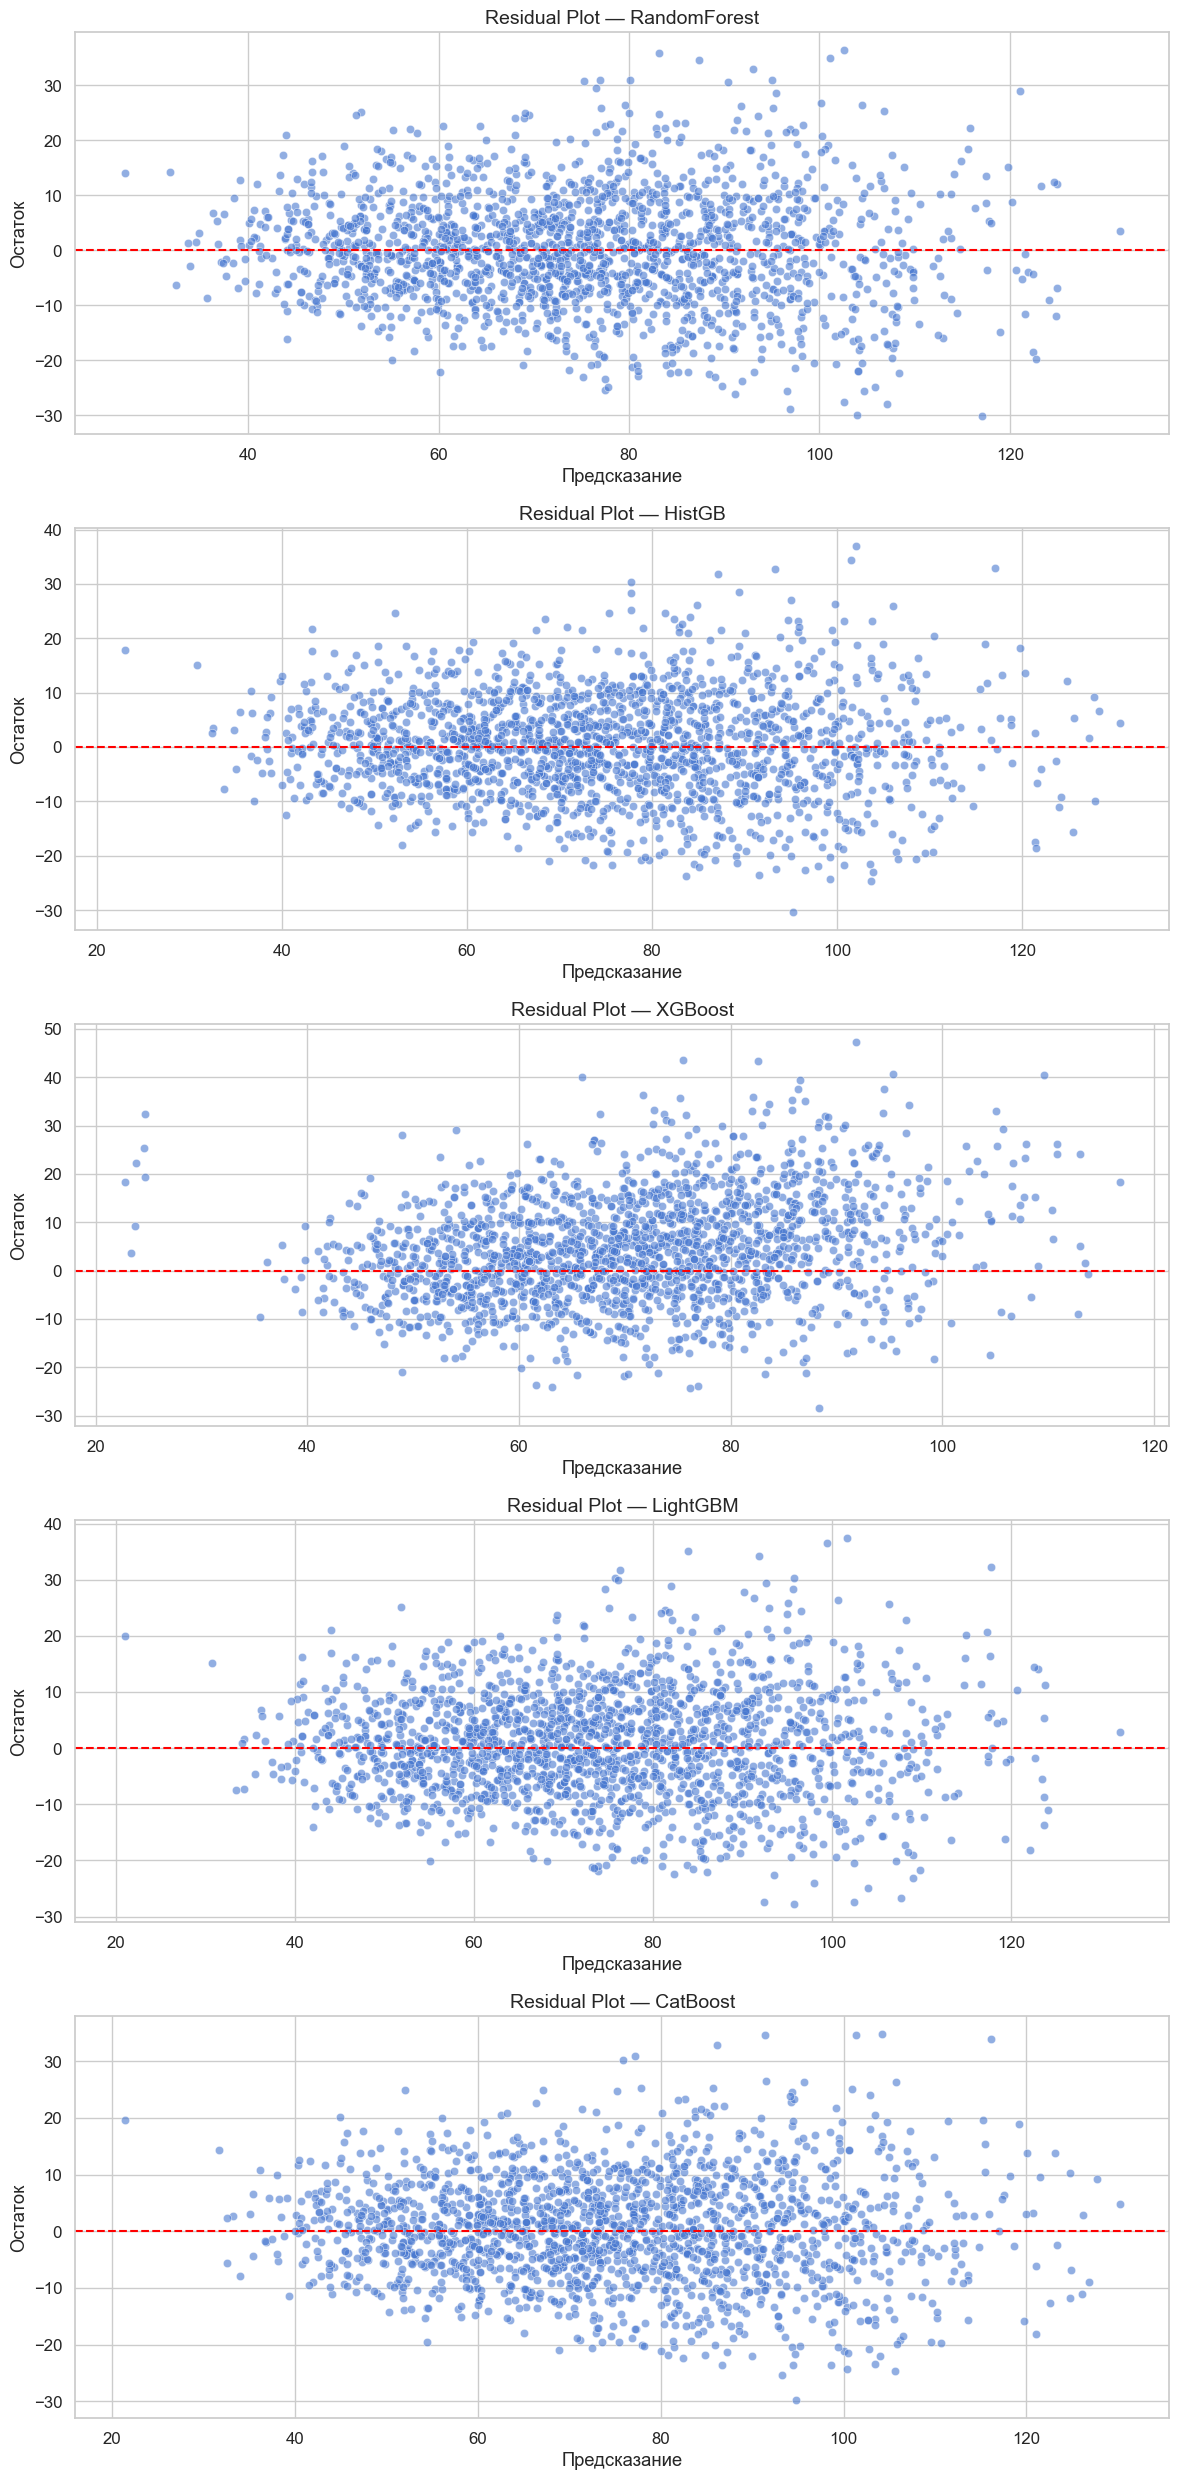

In [51]:
# График ошибок прогнозирования (по моделям)

import matplotlib.pyplot as plt
import seaborn as sns

# Уникальные модели
models = analytics_df['model'].unique()

# Размер фигуры: один график на модель
fig, axes = plt.subplots(len(models), 1, figsize=(12, 5 * len(models)), sharex=False)

for i, model_name in enumerate(models):
    ax = axes[i] if len(models) > 1 else axes
    model_data = analytics_df[analytics_df['model'] == model_name]

    sns.scatterplot(data=model_data, x="prediction", y="residual", alpha=0.6, ax=ax)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f"Residual Plot — {model_name}", fontsize=14)
    ax.set_xlabel("Предсказание")
    ax.set_ylabel("Остаток")
    ax.grid(True)

plt.tight_layout()
plt.show()


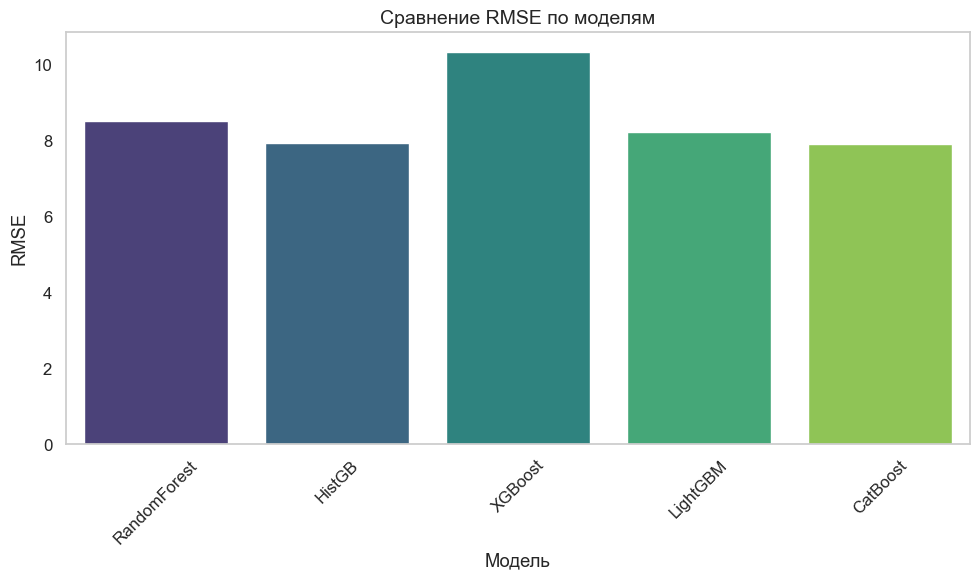

In [56]:
# RMSE по моделям (барплот метрик)

rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE']).reset_index()
rmse_df.columns = ['Model', 'RMSE']

plt.figure(figsize=(10, 6))
sns.barplot(data=rmse_df, x='Model', y='RMSE', hue='Model', palette='viridis', legend=False)
plt.title("Сравнение RMSE по моделям", fontsize=14)
plt.ylabel("RMSE")
plt.xlabel("Модель")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\maksd\AppData\Local\Temp\ipykernel_14804\4156754970.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='crest', ax=ax)
C:\Users\maksd\AppData\Local\Temp\ipykernel_14804\4156754970.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='crest', ax=ax)
C:\Users\maksd\AppData\Local\Temp\ipykernel_14804\4156754970.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='crest', ax=ax)
C:\Users\maksd\AppData\Local\Temp\ipy

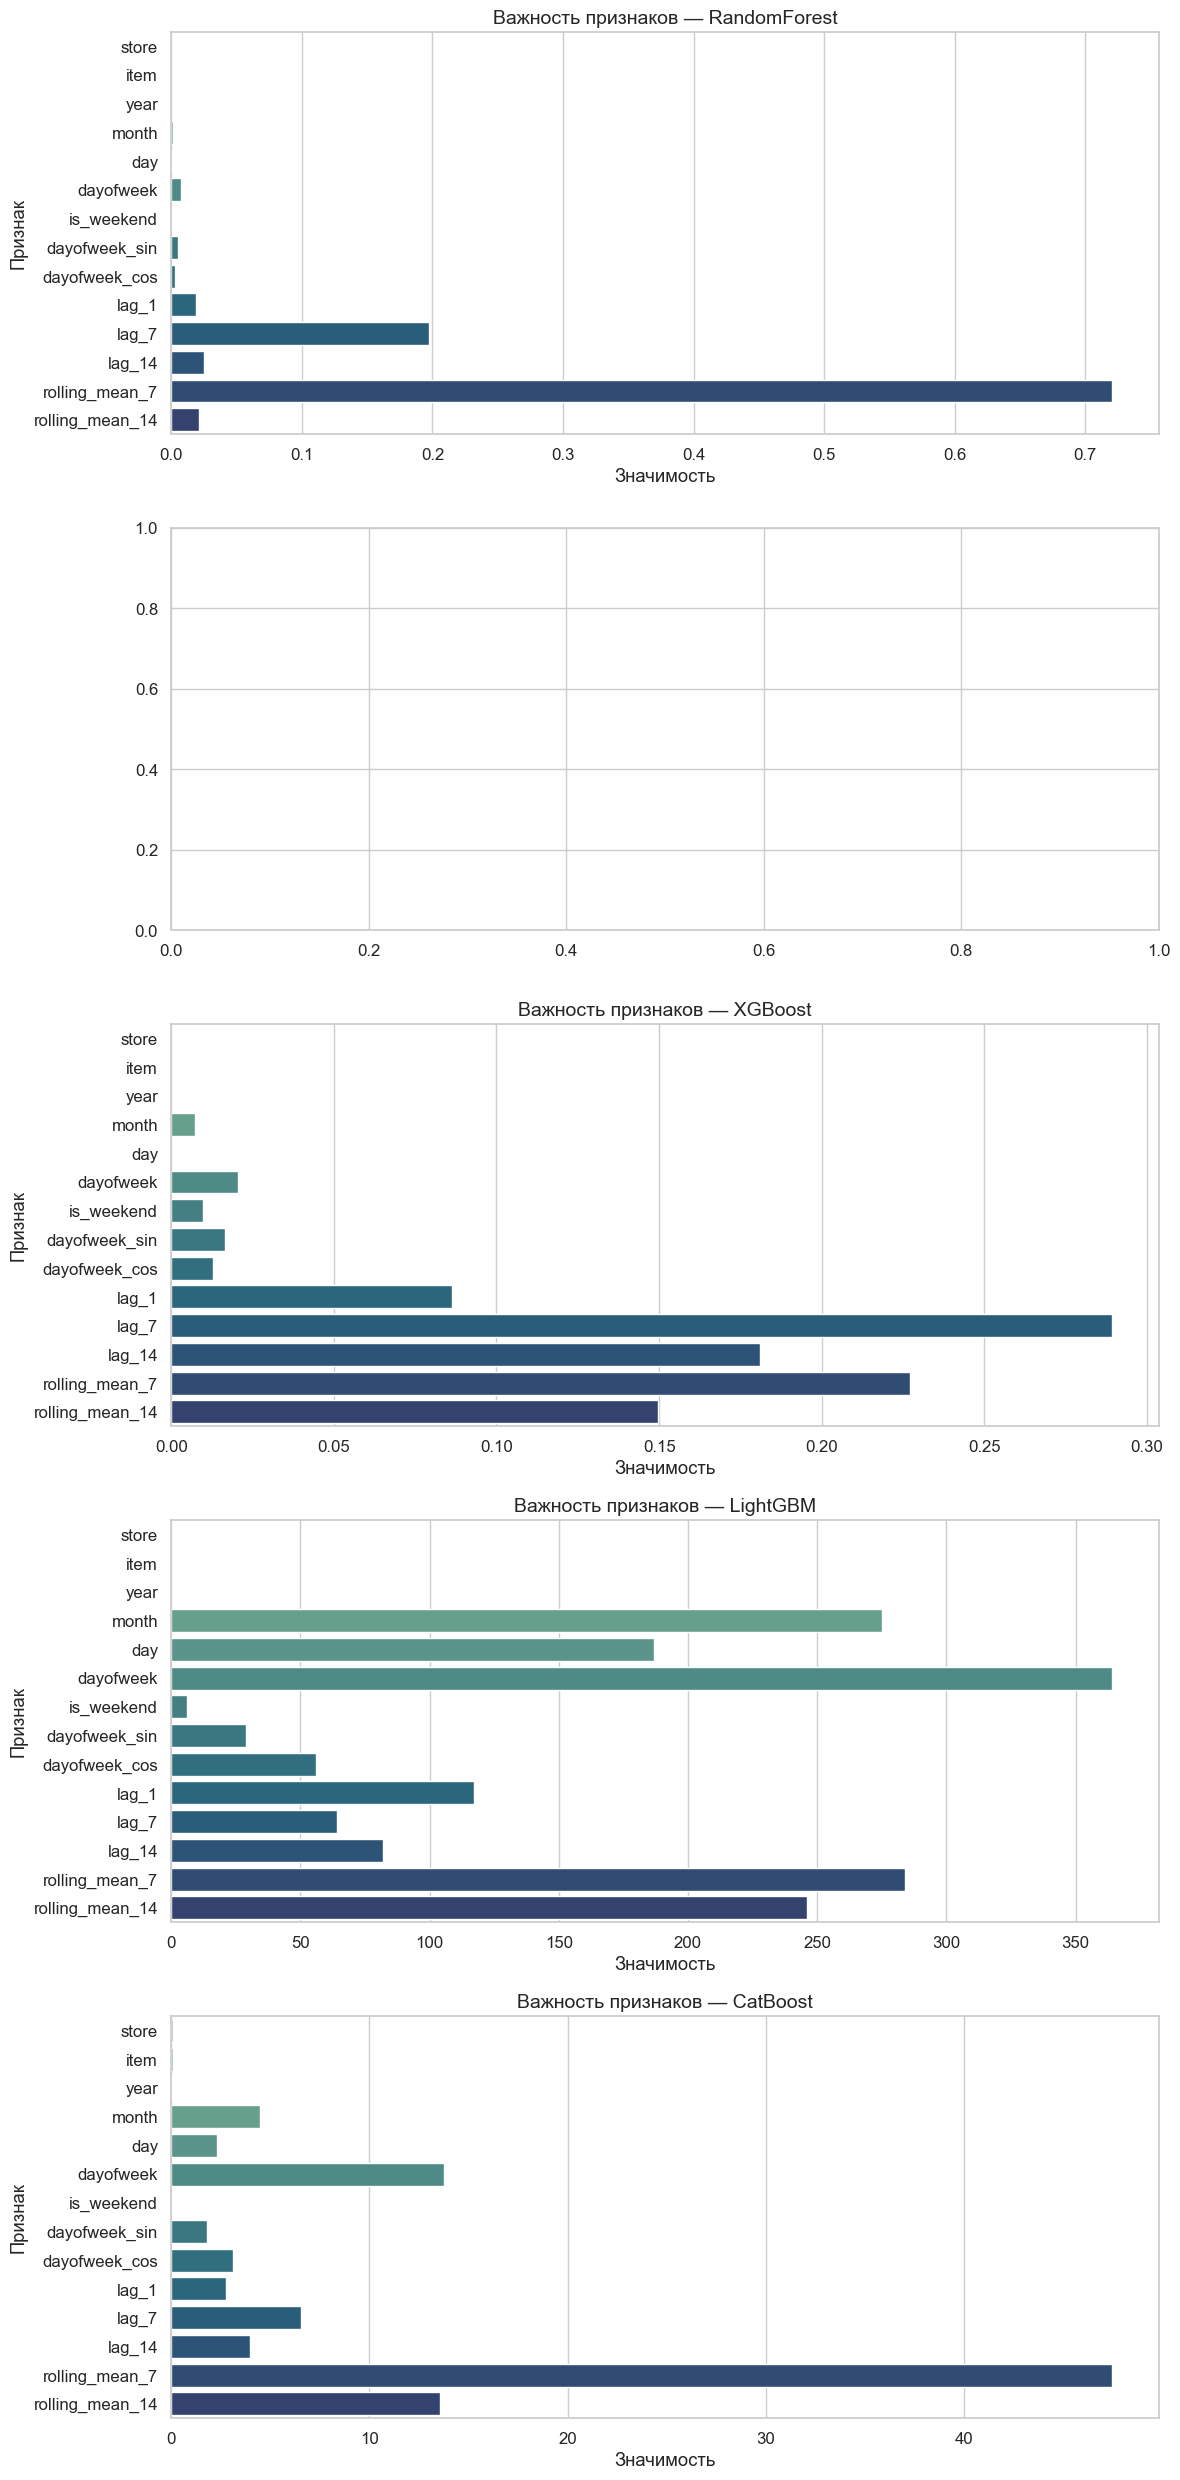

In [60]:
# Важность признаков (по каждой модели)

# Список моделей и объектов
model_dict = {
    "RandomForest": rf,
    "HistGB": hgb,
    "XGBoost": xgb,
    "LightGBM": lgb,
    "CatBoost": cat
}

feature_names = X.columns  # Или другой актуальный список

fig, axes = plt.subplots(len(model_dict), 1, figsize=(12, 5 * len(model_dict)), sharex=False)

for i, (model_name, model) in enumerate(model_dict.items()):
    ax = axes[i] if len(model_dict) > 1 else axes

    try:
        importances = model.feature_importances_
    except AttributeError:
        continue  # если модель не поддерживает feature_importances_

    sns.barplot(x=importances, y=feature_names, palette='crest', ax=ax)
    ax.set_title(f"Важность признаков — {model_name}", fontsize=14)
    ax.set_xlabel("Значимость")
    ax.set_ylabel("Признак")

plt.tight_layout()
plt.show()
